# SIR model for COVID-19 reproducing the paper from Ma, 2022

In [14]:
import numpy as np
import matplotlib as plt
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [15]:
%matplotlib widget
%config InlineBackend.figure_format='retina'

### Classic SIR model

\begin{align*} \frac{{dS\left(t \right)}}{{dt}} &= - \beta \frac{{S\left(t \right)I\left(t \right)}}{N} \tag{1}\\ \frac{{dI\left(t \right)}}{{dt}} &= \beta \frac{{S\left(t \right)I\left(t \right)}}{N} - \lambda I\left(t \right) \tag{2}\\ \frac{{dR\left(t \right)}}{{dt}} &= \lambda I\left(t \right) \tag{3} \end{align*}

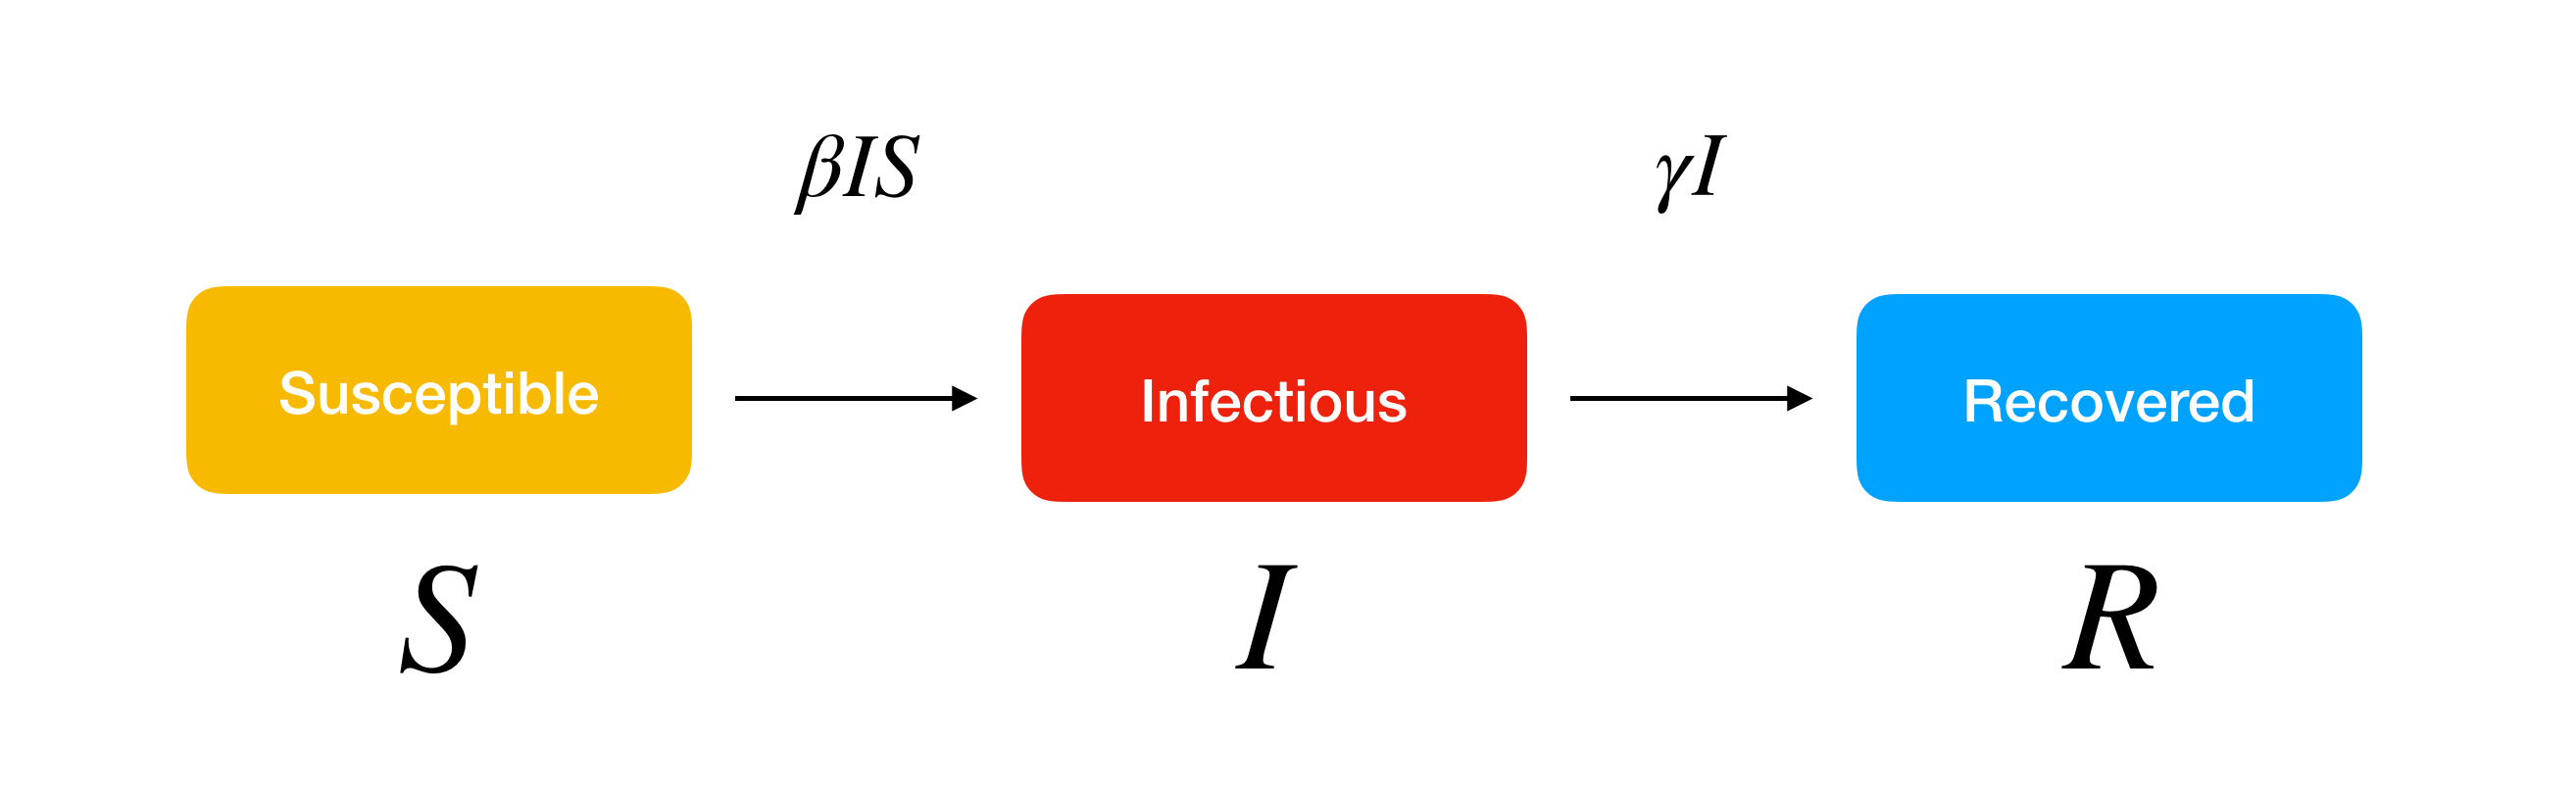

### Extended SEIR model

\begin{align*} \frac{{dS\left(t \right)}}{{dt}} &= - \beta \frac{{S\left(t \right)I\left(t \right)}}{N} - \alpha S\left(t \right) \tag{4}\\ \frac{{dE\left(t \right)}}{{dt}} &= \beta \frac{{S\left(t \right)I\left(t \right)}}{N} - \gamma E\left(t \right) \tag{5}\\ \frac{{dI\left(t \right)}}{{dt}} &= \gamma E\left(t \right) - \delta I\left(t \right) \tag{6}\\ \frac{{dQ\left(t \right)}}{{dt}} &= \delta I\left(t \right) - \lambda Q\left(t \right) - \kappa Q\left(t \right) \tag{7}\\ \frac{{dR\left(t \right)}}{{dt}} &= \lambda Q\left(t \right) \tag{8}\\ \frac{{dD\left(t \right)}}{{dt}} &= \kappa Q\left(t \right) \tag{9}\\ \frac{{dP\left(t \right)}}{{dt}} &= \alpha S\left(t \right) \tag{10} \end{align*}

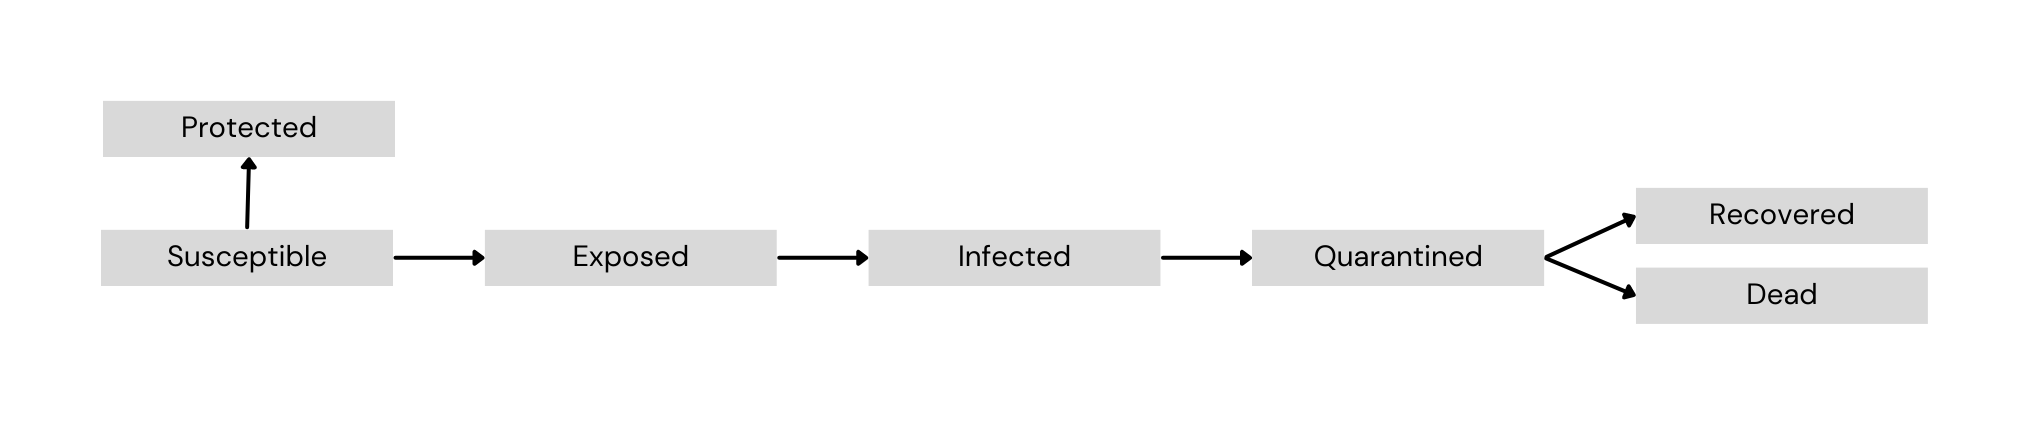

### States of the SEIR model

- $S$: susceptible people
- $E$: exposed people
- $I$: infected people not quarantined
- $Q$: infected people quarantined
- $P$: protected people
- $R$: recovered people
- $D$: dead people

### Parameters of the SEIR model
- $N$: total number of people
- $\alpha$: protection rate
- $\beta$: infectious rate
- $\gamma^{-1}$: average incubation time
- $\delta^{-1}$: average quarantine time
- $\lambda$: cure rate
- $\kappa$: mortality rate

In [16]:
# Define function for the system of differential equations
def seir_model(y, t, N, beta, alpha, gamma, delta, kappa, lam):
    S, E, I, Q, R, D, P = y
    dSdt = -beta*S*I/N - alpha*S
    dEdt = beta*S*I/N - gamma*E
    dIdt = gamma*E - delta*I
    dQdt = delta*I - lam*Q - kappa*Q
    dRdt = lam*Q
    dDdt = kappa*Q
    dPdt = alpha*S
    return dSdt, dEdt, dIdt, dQdt, dRdt, dDdt, dPdt

# Set initial conditions with values from the paper
N = 14000000
E0 = 318
I0 = 389
Q0 = 700
R0 = 0
D0 = 0
P0 = 0
S0 = N - E0 - I0 - Q0 - R0 - D0 - P0

#Set initial parameters with values from the paper
beta = 0.7      # infectious rate
alpha = 0.0185  # protection rate
gamma = 1/5     # gamma^(-1)=average incubation
delta = 1/7     # delta^(-1)=average quarantine time
kappa = 0.001   # mortality rate
lam = 0.1       # cure rate

# Set time discretization as in the paper
t = np.linspace(0, 180, 10000)

# Solve system of differential equations
# Returns the seven variables S, E, I, Q, R, D, and P at each time point
sol = odeint(seir_model, [S0, E0, I0, Q0, R0, D0, P0], t, args=(N, beta, alpha, gamma, delta, kappa, lam))


In [18]:
# Plot results

# dSdt, dEdt, dIdt, dQdt, dRdt, dDdt, dPdt
plt.plot(t,sol.T[0], label="susceptible people")
plt.plot(t,sol.T[1], label="exposed people")
plt.plot(t,sol.T[2], label="infected but not quarantined people")
plt.plot(t,sol.T[3], label="infected and quarantined people")
plt.plot(t,sol.T[4], label="recovered people")
plt.plot(t,sol.T[5], label="dead people")
plt.plot(t,sol.T[6], label="protected people")
plt.legend()

### Basic reproduction number

\begin{equation*} R0\ = \ \left({1 + \frac{{\ln (Y\left(t \right)/t)}}{\gamma }} \right)\left({1 + \frac{{\ln (Y\left(t \right)/t)}}{\lambda }} \right) \tag{11} \end{equation*}




In [19]:
# function to calculate R0 at a given time t
def calculate_R0(Y, t, gamma, lambd):
    return (1 + np.log(Y/t)/gamma) * (1 + np.log(Y/t)/lambd)


### Uncertainty quantification

In [20]:

from UQpy.run_model.RunModel import RunModel
from UQpy.run_model.model_execution.PythonModel import PythonModel
from UQpy.distributions import Uniform
from UQpy.distributions.collection.JointIndependent import JointIndependent
from UQpy.sensitivity.SobolSensitivity import SobolSensitivity
from UQpy.sensitivity.PostProcess import *


In [21]:
# Create Model object  

model = PythonModel(
    model_script="local_SEIR.py", # this file must be in the same folder
    model_object_name="solveSEIR", # this is the name of the main function called in local_SEIR.py
    var_names=["beta", #same order used when unpacking the parameters in solveSEIR
               "alpha",
               "gamma_inv",
               "delta_inv",
               "kappa",
               "lam"],
    delete_files=True #No idea what it means
)

runmodel_obj = RunModel(model=model)

The `Uniform` distribution is based on `scipy` and receives `loc` and `scale`, so if
$$
U\sim U([a,b]) \qquad f_U(x;a,b) = \frac{1}{b-a}
$$
then
$$
a = loc \qquad b = loc + scale
$$
therefore
$$
loc = a \qquad scale = b - a
$$

In [23]:
# Define distribution object - for now I set a uniform distribution around the init values (don'tknow why 
# but in the other notebooks they put the greater value firtst in the range)
B= Uniform(0.7, (0.9 - 0.7))
A= Uniform(0.085, (0.183 - 0.085 ))
G_inv=Uniform(5, (7 - 5 ))
D_inv=Uniform(7, (14 - 7))
L=Uniform(0.1, (0.5 - 0.1 ))
K=Uniform(0.001, (0.05 - 0.001 ))

dist_object = JointIndependent([B, A, G_inv, D_inv, K, L])

In [60]:
%%time
SA = SobolSensitivity(runmodel_obj, dist_object)
# Compute Sobol indices using the pick and freeze algorithm - for now low number of samples
SA.run(n_samples=5000, estimate_second_order=False)

CPU times: user 2min 21s, sys: 26.9 s, total: 2min 48s
Wall time: 3min 15s


In [61]:
np.shape(SA.first_order_indices)

(6, 10000)

In [26]:
SA.first_order_confidence_interval

In [27]:
SA.first_order_indices.T[1:]

array([[-0.00077594, -0.00073164,  0.30752058,  0.68994731, -0.00073146,
        -0.00073146],
       [-0.00088651, -0.00082376,  0.30965926,  0.68761916, -0.00082304,
        -0.00082304],
       [-0.00097257, -0.00091673,  0.31176679,  0.68529663, -0.00091512,
        -0.00091512],
       ...,
       [-0.02717675,  0.10263367, -0.03789731,  0.42765408, -0.03943825,
        -0.03943825],
       [-0.02717579,  0.10261176, -0.0378964 ,  0.42766453, -0.03943735,
        -0.03943735],
       [-0.02717482,  0.10258986, -0.03789549,  0.42767497, -0.03943645,
        -0.03943645]])

In [11]:
#Capire perchè non funziona
np.shape(SA.first_order_confidence_interval)

()

In [62]:
np.shape(SA.first_order_indices.T[1:,i])

(9999,)

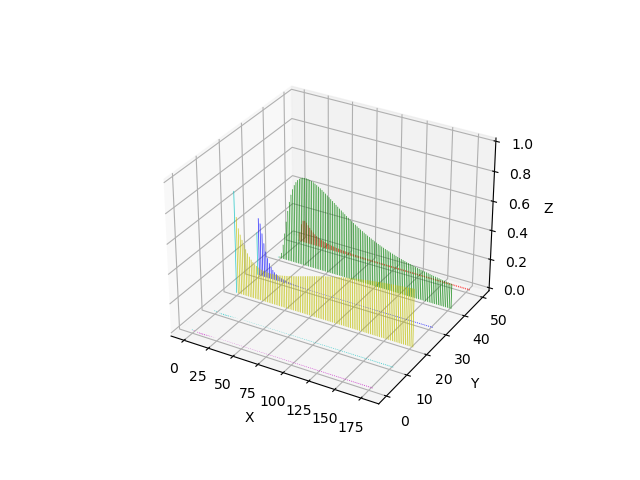

In [63]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

t_0 = 0
t_f = 180
n_t = 10000
T = np.linspace(t_0, t_f, n_t)

T = T[1:]

fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

c = ['r', 'g', 'b', 'y', 'c', 'm']
z = [50, 40, 30, 20, 10, 0]

for i in range(np.shape(SA.first_order_indices.T[1:])[1]):
    xs = T
    ys = SA.first_order_indices.T[1:,i]
    
    xs = xs[::100]
    ys = ys[::100]

    # You can provide either a single color or an array. To demonstrate this,
    # the first bar of each set will be colored cyan.
    cs = [c[i]] * len(xs)
    cs[0] = 'c'
    ax.bar(xs, ys, zs=z[i], zdir='y', color=cs, alpha=0.8)

ax.set_zlim(0,1)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [85]:
starting_time

278

### Plotting first order Sobol indices in time

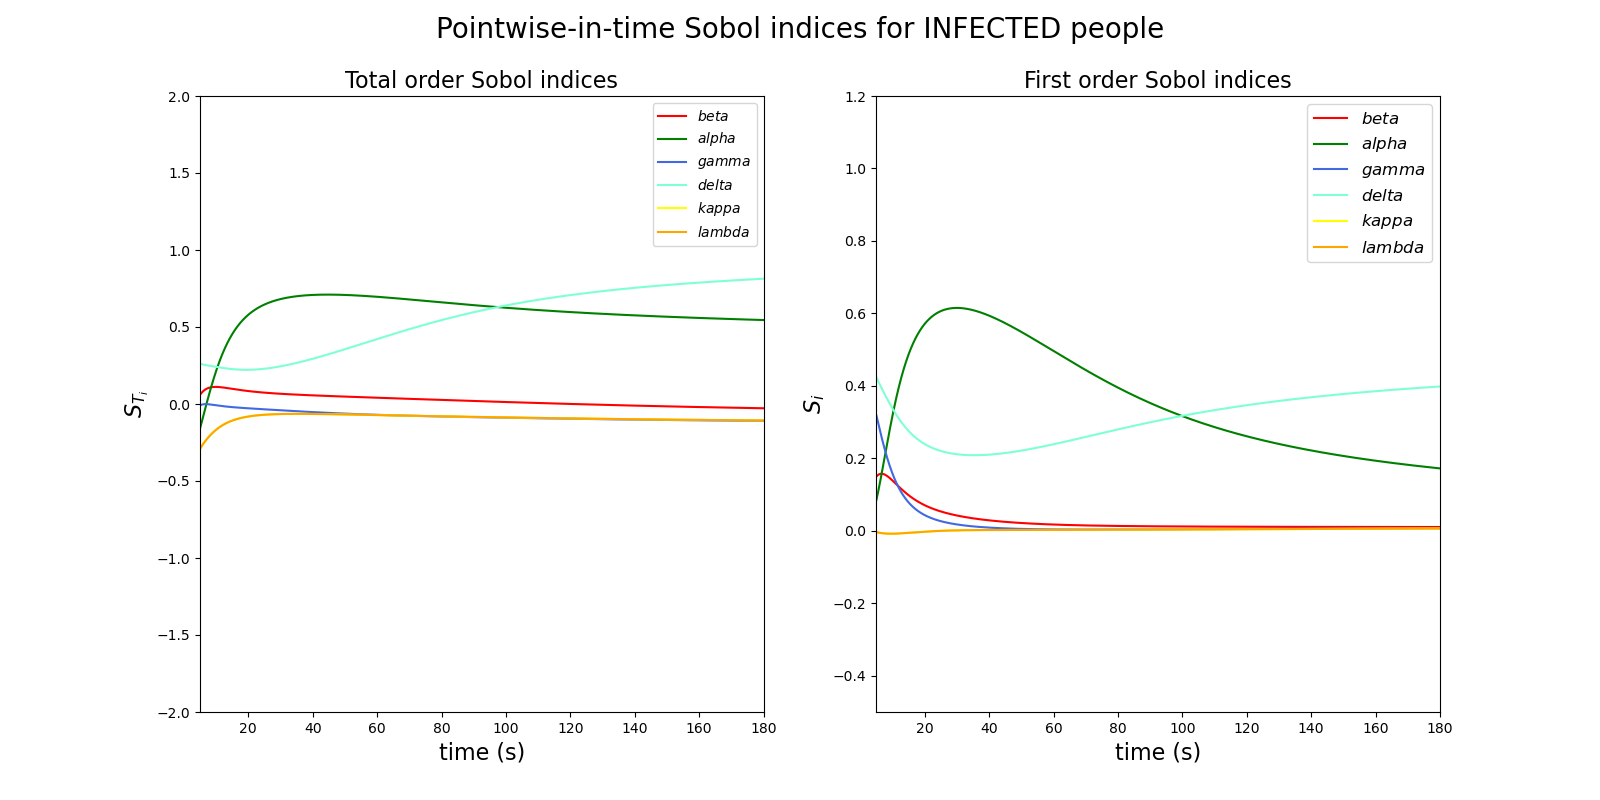

In [86]:

t_0 = 0
t_f = 180
n_t = 10000
T = np.linspace(t_0, t_f, n_t)


fig, ax = plt.subplots(1, 2, figsize=(16, 8))

#Plotting from day 5
starting_day=5
starting_time=int(np.ceil(n_t/(t_f-t_0)*starting_day))

ax[0].plot(T[starting_time:], SA.total_order_indices[0, starting_time:], "r" ,label=r"$beta$")
ax[0].plot(T[starting_time:], SA.total_order_indices[1, starting_time:], "g",label=r"$alpha$")
ax[0].plot(T[starting_time:], SA.total_order_indices[2, starting_time:], label=r"$gamma$", color="royalblue")
ax[0].plot(T[starting_time:], SA.total_order_indices[3, starting_time:], label=r"$delta$", color="aquamarine")
ax[0].plot(T[starting_time:], SA.total_order_indices[4, starting_time:], label=r"$kappa$", color="yellow")
ax[0].plot(T[starting_time:], SA.total_order_indices[5, starting_time:], label=r"$lambda$", color="orange")


ax[0].set_title("Total order Sobol indices", fontsize=16)
ax[0].set_xlabel("time (s)", fontsize=16)
ax[0].set_ylabel(r"$S_{T_i}$", fontsize=16)
ax[0].set_xbound(starting_day, t_f)
ax[0].set_ybound(-2, 2)
ax[0].legend()

ax[1].plot(T[starting_time:], SA.first_order_indices[0, starting_time:], "r" ,label=r"$beta$")
ax[1].plot(T[starting_time:], SA.first_order_indices[1, starting_time:], "g",label=r"$alpha$")
ax[1].plot(T[starting_time:], SA.first_order_indices[2, starting_time:], label=r"$gamma$", color="royalblue")
ax[1].plot(T[starting_time:], SA.first_order_indices[3, starting_time:], label=r"$delta$", color="aquamarine")
ax[1].plot(T[starting_time:], SA.first_order_indices[4, starting_time:], label=r"$kappa$", color="yellow")
ax[1].plot(T[starting_time:], SA.first_order_indices[5, starting_time:], label=r"$lambda$", color="orange")


ax[1].set_title("First order Sobol indices", fontsize=16)
ax[1].set_xlabel("time (s)", fontsize=16)
ax[1].set_ylabel(r"$S_i$", fontsize=16)
ax[1].set_xbound(starting_day, t_f)
ax[1].set_ybound(-0.5, 1.2)
ax[1].legend(fontsize=12)


##The order is still not clear
#ax[2].plot(T, SA.second_order_indices[0, :], "r" ,label=r"$beta$")
#ax[2].plot(T, SA.second_order_indices[1, :], "g",label=r"$alpha$")
#ax[2].plot(T, SA.second_order_indices[2, :], label=r"$gamma$", color="royalblue")
#ax[2].plot(T, SA.second_order_indices[3, :], label=r"$delta$", color="aquamarine")
#ax[2].plot(T, SA.second_order_indices[4, :], label=r"$kappa$", color="yellow")
#ax[2].plot(T, SA.second_order_indices[5, :], label=r"$lambda$", color="orange")
#ax[2].plot(T, SA.second_order_indices[6, :], label=r"$lambda$", color="orange")
#ax[2].plot(T, SA.second_order_indices[7, :], label=r"$lambda$", color="orange")
#ax[2].plot(T, SA.second_order_indices[8, :], label=r"$lambda$", color="orange")
#ax[2].plot(T, SA.second_order_indices[9, :], label=r"$lambda$", color="orange")
#ax[2].plot(T, SA.second_order_indices[10, :], label=r"$lambda$", color="orange")
#
#
#ax[2].set_title("Second order Sobol indices", fontsize=16)
#ax[2].set_xlabel("time (s)", fontsize=16)
#ax[2].set_ylabel(r"$S_i$", fontsize=16)
#ax[2].set_xbound(0, t_f)
#ax[2].set_ybound(-0.5, 1.2)
#ax[2].legend(fontsize=12)
#
fig.suptitle("Pointwise-in-time Sobol indices for INFECTED people", fontsize=20)

plt.show()

## Barplots - in progress

In [65]:
first_order_sobol_mean=np.array(np.zeros(6))
total_sobol_mean=np.array(np.zeros(6))

#Starting from iteration 100 to avoid numerical instabilities
for i in range(6):
    first_order_sobol_mean[i]=np.mean(SA.first_order_indices[i, 100:])
    total_sobol_mean[i]=np.mean(SA.total_order_indices[i, 100:])

In [67]:
total_sobol_mean

array([ 0.02233241,  0.58219505, -0.0775955 ,  0.54905062, -0.0966357 ,
       -0.0966357 ])

In [68]:
first_order_sobol_mean

array([0.02750528, 0.35460552, 0.02444109, 0.31049449, 0.00299583,
       0.00299583])

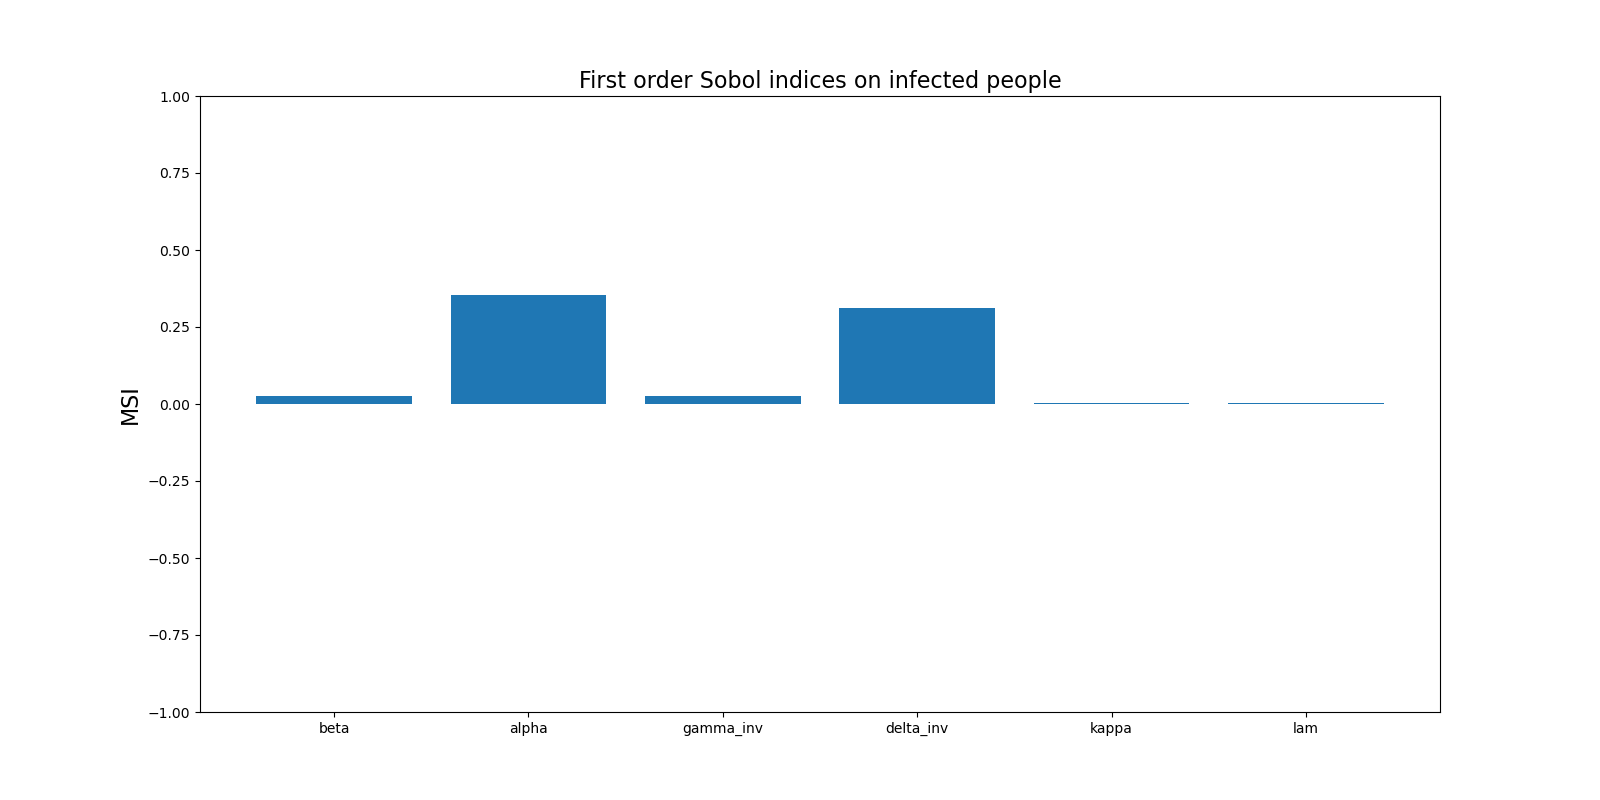

In [70]:
var_names=["beta", #same order used when unpacking the parameters in solveSEIR
               "alpha",
               "gamma_inv",
               "delta_inv",
               "kappa",
               "lam"]

plt.clf()
plt.bar(var_names, first_order_sobol_mean)
# Add labels and title
#plt.xlabel(var_names)
plt.ylim(-1,1)
plt.ylabel('MSI',fontsize=16)
plt.title('First order Sobol indices on infected people',fontsize=16)

# Show the plot
plt.show()




### Comments:
- i loro sembrano diversi, siamo sicuri facciano la media? Mi documento